# Honor Statement

Name: Zhuoran Wu

E-mail: <zw118@georgetown.edu>

Platform: Windows

In accordance with the class policies and Georgetown's Honor Code,
I certify that, with the exceptions of the class resources and those
items noted below, I have neither given nor received any assistance
on this project.

In [41]:
# Import Library

%matplotlib inline

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import itertools

from string import printable
from keras import backend as K
from skimage.transform import resize
from keras.datasets import fashion_mnist
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization, Lambda, Convolution1D, Convolution2D, ELU, concatenate
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from keras.optimizers import SGD, Adam, RMSprop

import warnings
warnings.filterwarnings("ignore")

# 1 Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.

Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we've used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html.

After training your network, visualize some examples of input images and
their decoded reconstruction.

In [42]:
# Autoencoder

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Data normalization

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [43]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4608      
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
__________

In [46]:
autoencoder_history = autoencoder.fit(x_train, x_train,
                                      epochs=3,
                                      batch_size=64,
                                      validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 323s 5ms/step - loss: 0.2851 - val_loss: 0.2848
Epoch 2/3
60000/60000 [==============================] - 315s 5ms/step - loss: 0.2807 - val_loss: 0.2795
Epoch 3/3
60000/60000 [==============================] - 319s 5ms/step - loss: 0.2781 - val_loss: 0.2776


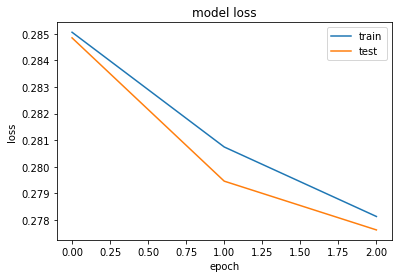

In [47]:
# Evaluate

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(autoencoder_history)

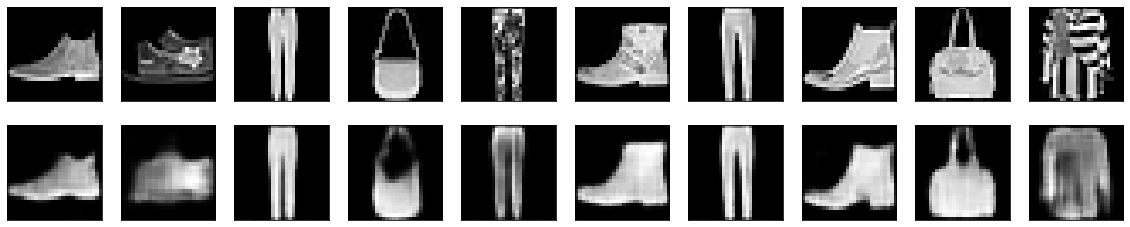

In [48]:
# Display original and reconstruction Images

decoded_imgs = autoencoder.predict(x_test)

def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[-i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[-i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

display_reconstructed(x_test, decoded_imgs, 10)

# 2 Image Classification

We'll continue to use the Fashion MNIST dataset and build a deep convolutional
network for classification.

## 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you've made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model's performance on training
set and test set.

## 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the major-
ity of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet,VGG, etc). Report on your model's performance on training set and test set.

In [49]:
# Deep CNN

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)

# Data normalization

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

model = Sequential()
# Must define the input shape in the first layer of the neural network
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
__________

In [27]:
deep_cnn_history = model.fit(x_train,
                             y_train,
                             batch_size=64,
                             epochs=10,
                             validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 76s 1ms/step - loss: 0.5903 - acc: 0.7836 - val_loss: 0.3974 - val_acc: 0.8525
Epoch 2/10
60000/60000 [==============================] - 77s 1ms/step - loss: 0.4107 - acc: 0.8516 - val_loss: 0.3296 - val_acc: 0.8819
Epoch 3/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.3650 - acc: 0.8671 - val_loss: 0.3007 - val_acc: 0.8896
Epoch 4/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3379 - acc: 0.8764 - val_loss: 0.2911 - val_acc: 0.8924
Epoch 5/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3202 - acc: 0.8823 - val_loss: 0.2795 - val_acc: 0.8976
Epoch 6/10
60000/60000 [==============================] - 97s 2ms/step - loss: 0.3031 - acc: 0.8890 - val_loss: 0.2751 - val_acc: 0.8979
Epoch 7/10
60000/60000 [==============================] - 91s 2ms/step - loss: 0.2899 - acc: 0.8931 - val_loss: 0.2608 - val_acc

10000/10000 [==============================] - 3s 329us/step
The test score: [0.2516078155398369, 0.9094]


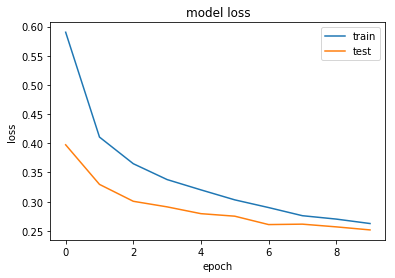

In [28]:
# Evaluate and Plot history

score = model.evaluate(x_test, y_test, verbose=1)

print("The test score: {acc}".format(acc = score))


def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(deep_cnn_history)

In [50]:
# Transfer Learning

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Convert the images into 3 channels
# x_train=np.dstack([x_train] * 3)
# x_test=np.dstack([x_test]*3)

x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,1).astype('float32')

x_train = x_train / 255
x_test = x_test / 255

#label for each image
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [59]:
number_of_classes = y_test.shape[1]
input_image = Input(shape=(48,48))
inputs = Lambda(lambda x: K.repeat_elements(K.expand_dims(x,3),3,3))(input_image)
vgg = VGG16(weights = "imagenet", include_top=False, input_tensor = inputs,pooling='max', classes=number_of_classes)
#vgg.summary()

for layer in vgg.layers[:17]:
    layer.trainable = False

x = vgg.output
#x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(number_of_classes, activation="softmax")(x)

# creating the final model 
final_model = Model(inputs = vgg.input, outputs = predictions)
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48)            0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
__________

In [ ]:
batch_size = 150
epochs = 5
#model = create_model()
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = final_model.fit(x_train_bis, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

In [ ]:
# Evaluate the model 
score = final_model.evaluate(x_test, y_test, verbose=0)
print('Test Loss and Accuracy:', score)

In [ ]:
# Accuracy visualization
training_accuracy = history.history['acc']
testing_accuracy = history.history['val_acc']
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.title('Model accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Loss visualization

training_loss = history.history['loss']
testing_loss = history.history['val_loss']
plt.plot(training_loss)
plt.plot(testing_loss)
plt.title('Model loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

# 3 Text Classification

While images contain local spatial correlations and structure, many other datasets
contain temporal correlations. Examples include time series and discrete se-
quences such as text. In this problem, we will tackle the task of text classifica-
tion in the context of cybersecurity.

**Background.** When malware infects a host computer, it often needs to
reach out to an outside server for further instructions or to download additional
payloads. This outside server is called a Command-and-Control server (C2).
The malware needs to send a specific communication to the C2 server, thus the
C2 server needs to have a registered IP address or associated web domain so
that it can be reached. Therefore, being able to identify web domains that are
likely related to malware C2 can be a valuable cyber defense.

**Dataset.** Fortunately, security researchers have already identified and logged
a large number of malicious URLs. Additionally, we can catalog common "be-
nign" URLs just from typical web behavior (these would include things like
facebook.com and amazon.com). Hence, we have a labeled dataset for text
classification which can be downloaded here:

* https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt

* https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt


## 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classification task.
You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

## 3.2 CNN

Build and train a 1D CNN for this text classification task. You might gain some
insight and inspiration from these text classification approaches:

* http://www.aclweb.org/anthology/D14-1181

* https://arxiv.org/abs/1702.08568

## 3.3

Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don't forget to create a train-test split.

In [51]:
# Text Classification

# Load Malicious Url

with open("malicious-urls.txt") as files:
    lines = files.readlines()
mal_url_strings = [line.rstrip("\n\r") for line in lines[0:]]

with open("benign-urls.txt") as files:
    lines = files.readlines()
ben_url_strings = [line.rstrip("\n\r") for line in lines[0:] if "#" not in line]

In [52]:
x_train = ben_url_strings + mal_url_strings
y_train = np.concatenate( [ np.ones(len(ben_url_strings)), np.zeros(len(mal_url_strings)) ])

In [53]:
df = pd.DataFrame({'urls':x_train, 'label':y_train})

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.urls]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = pad_sequences(url_int_tokens, maxlen=max_len)
 
# Step 3: Extract labels form df to numpy array
target = np.array(df.label)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (67311, 75) Vector dimension of target:  (67311,)


In [54]:
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.25, random_state=33)

In [55]:
# LSTM Model

max_len=75
emb_dim=32
max_vocab_len=100
lstm_output_size=32
W_reg=regularizers.l2(1e-4)

main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
# Embedding layer
emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
            dropout=0.2, W_regularizer=W_reg)(main_input) 

# LSTM layer
lstm = LSTM(lstm_output_size)(emb)
lstm = Dropout(0.5)(lstm)

# Output layer (last fully connected layer)
output = Dense(1, activation='sigmoid', name='output')(lstm)

# Compile model and define optimizer
model = Model(input=[main_input], output=[output])
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 75)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 75, 32)            3200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_27 (Dropout)         (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


In [23]:
epochs = 3
batch_size = 32

model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size)

Epoch 1/3
50483/50483 [==============================] - 65s 1ms/step - loss: 0.0466 - acc: 0.9812
Epoch 2/3
50483/50483 [==============================] - 66s 1ms/step - loss: 0.0365 - acc: 0.9813
Epoch 3/3
50483/50483 [==============================] - 64s 1ms/step - loss: 0.0309 - acc: 0.9832


In [24]:
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)
print('\nFinal Cross-Validation Accuracy', accuracy, '\n')

16828/16828 [==============================] - 4s 216us/step

Final Cross-Validation Accuracy 0.9831233658472093 



In [56]:
# CNN Model

max_len=75
emb_dim=32
max_vocab_len=100
W_reg=regularizers.l2(1e-4)

# Input
main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
# Embedding layer
emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
            W_regularizer=W_reg)(main_input) 
emb = Dropout(0.25)(emb)


def sum_1d(X):
    return K.sum(X, axis=1)

def get_conv_layer(emb, kernel_size=5, filters=256):
    # Conv layer
    conv = Convolution1D(kernel_size=kernel_size, filters=filters, \
                 border_mode='same')(emb)
    conv = ELU()(conv)

    conv = Lambda(sum_1d, output_shape=(filters,))(conv)
    #conv = BatchNormalization(mode=0)(conv)
    conv = Dropout(0.5)(conv)
    return conv

# Multiple Conv Layers

# calling custom conv function from above
conv1 = get_conv_layer(emb, kernel_size=2, filters=256)
conv2 = get_conv_layer(emb, kernel_size=3, filters=256)
conv3 = get_conv_layer(emb, kernel_size=4, filters=256)
conv4 = get_conv_layer(emb, kernel_size=5, filters=256)

# Fully Connected Layers
merged = concatenate([conv1,conv2,conv3,conv4], axis=1)

hidden1 = Dense(1024)(merged)
hidden1 = ELU()(hidden1)
hidden1 = BatchNormalization(mode=0)(hidden1)
hidden1 = Dropout(0.5)(hidden1)

hidden2 = Dense(1024)(hidden1)
hidden2 = ELU()(hidden2)
hidden2 = BatchNormalization(mode=0)(hidden2)
hidden2 = Dropout(0.5)(hidden2)

# Output layer (last fully connected layer)
output = Dense(1, activation='sigmoid', name='output')(hidden2)

# Compile model and define optimizer
cnn_model = Model(input=[main_input], output=[output])
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cnn_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 75, 32)       3200        main_input[0][0]                 
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 75, 32)       0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 75, 256)      16640       dropout_28[0][0]                 
__________________________________________________________________________________________________
conv1d_14 

In [36]:
epochs = 5
batch_size = 32

cnn_model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size)

Epoch 1/5
50483/50483 [==============================] - 115s 2ms/step - loss: 0.3461 - acc: 0.8568
Epoch 2/5
50483/50483 [==============================] - 119s 2ms/step - loss: 0.1199 - acc: 0.9723
Epoch 3/5
50483/50483 [==============================] - 128s 3ms/step - loss: 0.1022 - acc: 0.9757
Epoch 4/5
50483/50483 [==============================] - 128s 3ms/step - loss: 0.0944 - acc: 0.9759
Epoch 5/5
50483/50483 [==============================] - 127s 3ms/step - loss: 0.0790 - acc: 0.9777


In [37]:
loss, accuracy = cnn_model.evaluate(X_test, target_test, verbose=1)
print('\nFinal Cross-Validation Accuracy', accuracy, '\n')

16828/16828 [==============================] - 8s 504us/step

Final Cross-Validation Accuracy 0.9825291180939354 



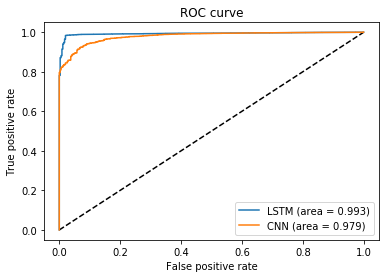

In [40]:
# LSTM and CNN ROC Curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(target_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

cnn_y_pred_keras = cnn_model.predict(X_test).ravel()
cnn_fpr_keras, cnn_tpr_keras, cnn_thresholds_keras = roc_curve(target_test, cnn_y_pred_keras)
cnn_auc_keras = auc(cnn_fpr_keras, cnn_tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.plot(cnn_fpr_keras, cnn_tpr_keras, label='CNN (area = {:.3f})'.format(cnn_auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()